<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir("/content/drive/MyDrive/StockML /Data/")

['papers.csv',
 'companyInfo',
 'starHistory',
 '.ipynb_checkpoints',
 'forkHistory',
 'issueHistory',
 'commitHistory',
 'issueClosedHistory',
 'pullRequestClosedHistory',
 'pullRequestMergedHistory',
 'pullRequestHistory',
 'rawData',
 'processedData',
 'financialData']

In [ ]:
#calculate the daily cumulative for each company
companies = pd.read_csv("/content/drive/MyDrive/StockML /Data/companyInfo/companies_final.csv")
dataCategories = []
for name in os.listdir("/content/drive/MyDrive/StockML /Data/"):
  if "History" in name: #if is a part of the raw data
    dataCategories.append(name)

for i in range(companies.shape[0]):
  company = companies.at[i, 'githubUser']
  normalizedName = companies.at[i, "shortName"]
  print(company, normalizedName)
  cumulativeData = {}
  cumulativeData["date"] = list(pd.date_range(start="1/01/1999", end='9/01/2021').tz_localize(None)) #need to check the timezone
  #calculate the cumulative data for each category
  for category in dataCategories:
    print(category[:-7])
    df = pd.read_csv("/content/drive/MyDrive/StockML /Data/"+category+"/"+company+".csv")
    df["sum"] = df.sum(axis=1)
    cumulativeData[category[:-7]] = list(df["sum"])
  cumulativeData = pd.DataFrame(cumulativeData)
  cumulativeData.to_csv("/content/drive/MyDrive/StockML /Data/processedData/cumulativeData/"+company+".csv")
  if(i==13): #currently only have the data for 14 companies (stopped at wix)
    break

amzn Amazon
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
slackapi Slack
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
cisco Cisco
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
elastic Elastic
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
netflix Netflix
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
pinterest Pinterest
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
shutterstock Shutterstock
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
intuit intuit
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
okta Okta
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
shopify Shopify
star
fork
issue
commit
issueClosed
pullRequestClosed
pullRequestMerged
pullRequest
airbnb Airbnb

In [37]:
import requests
company = "amzn"
response = requests.get("https://api.github.com/users/"+company)
data = response.json()
created_at = data['created_at']

In [80]:
from pandas_datareader import data as pdr
from datetime import date

#natural date range (creation date of the company's github page --- 2021-04-30)
start_date = pd.to_datetime(created_at[:10]).tz_localize(None)
end_date = pd.to_datetime("2021-04-30").tz_localize(None)
#for amzn, the first week start on 2014-09-02, the last week end on 2021-04-30
start_date = pd.to_datetime("2019-09-02").tz_localize(None)

#select the stock data within the date range
stockPrice = pd.read_csv("/content/drive/MyDrive/StockML /Data/financialData/AMZN.csv")
stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
mask = (pd.to_datetime(stockPrice['Date'])>= start_date) & (pd.to_datetime(stockPrice['Date']) <= end_date)
stockDataSelected = stockPrice.loc[mask].reset_index()

#select the cumulative data within the date range
mask = (cumulativeData['date'] >= start_date) & (cumulativeData['date'] <= end_date)
cumulativeDataSelected = cumulativeData.loc[mask].reset_index()
display(cumulativeDataSelected)

,index,date,star,fork,issue,commit,issueClosed,pullRequestClosed,pullRequestMerged,pullRequest
0,7549,2019-09-02,2,0,1,33,0,0,0,5
1,7550,2019-09-03,6,1,2,18,2,2,2,0
2,7551,2019-09-04,2,1,6,10,3,5,4,3
3,7552,2019-09-05,2,1,7,39,3,6,5,4
4,7553,2019-09-06,3,0,3,9,5,4,4,5
...,...,...,...,...,...,...,...,...,...,...
602,8151,2021-04-26,16,11,8,14,7,7,4,8
603,8152,2021-04-27,13,3,8,8,2,7,7,4
604,8153,2021-04-28,34,4,7,19,4,6,6,6
605,8154,2021-04-29,39,8,13,13,7,6,6,5


In [81]:
import scipy.stats
import numpy as np

x = np.array(list(stockDataSelected['Open']))
y = []

#remove the dates not in x
stockDates = list(stockDataSelected['Date'])
for i in range(cumulativeDataSelected.shape[0]):
  if(cumulativeDataSelected.at[i, 'date'] in stockDates):
    y.append(cumulativeDataSelected.at[i, 'pullRequest']+cumulativeDataSelected.at[i, 'star']+cumulativeDataSelected.at[i, 'issue'])
y = np.array(y)

print(x.shape, y.shape)

print("Pearson:", scipy.stats.pearsonr(x, y))
print("Spearman:", scipy.stats.spearmanr(x, y))
print("Kendall:", scipy.stats.kendalltau(x, y))

(419,) (419,)
Pearson: (0.0250318125884401, 0.6093946222526339)
Spearman: SpearmanrResult(correlation=0.4032129545699205, pvalue=8.213009227285086e-18)
Kendall: KendalltauResult(correlation=0.2781943741900905, pvalue=6.185056183138645e-17)


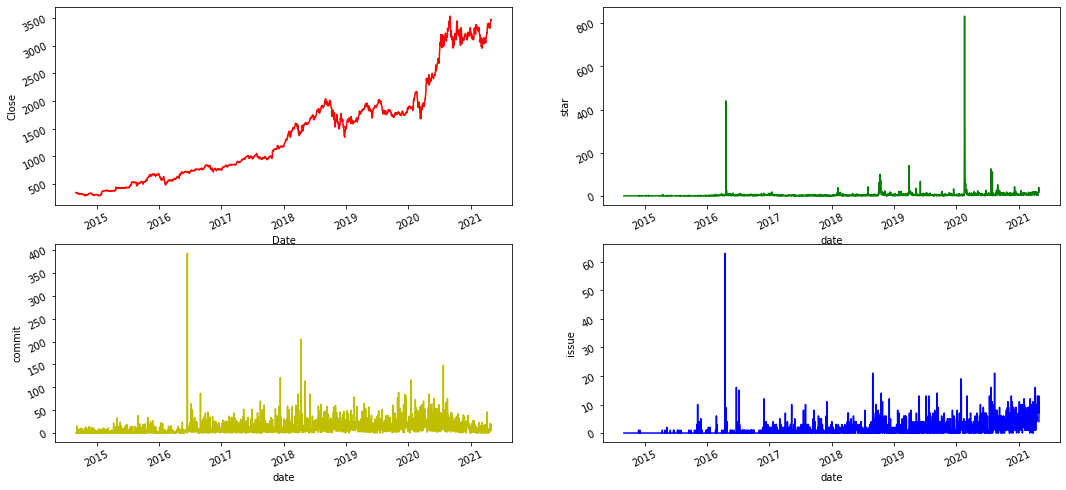

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.lineplot(x = "Date", y = "Close", data = stockDataSelected)
#sns.lineplot(x = "date", y = "star", data = cumulativeDataSelected)

fig,ax =  plt.subplots( 2, 2, figsize = ( 18, 8))

sns.lineplot(x = "Date", y = "Close", color = "r", data = stockDataSelected, ax = ax[0][0])
ax[0][0].tick_params(labelrotation = 25)

sns.lineplot(x = "date", y = "star", color = "g", data = cumulativeDataSelected, ax = ax[0][1])
ax[0][1].tick_params(labelrotation = 25)

sns.lineplot(x = "date", y = "commit", color = "y", data = cumulativeDataSelected, ax = ax[1][0])
ax[1][0].tick_params(labelrotation = 25)

sns.lineplot(x = "date", y = "issue", color = "b", data = cumulativeDataSelected, ax = ax[1][1])
ax[1][1].tick_params(labelrotation = 25)
